Examine dependence of info flow between pre- and post-synaptic neuron on neuronal excitability.

In [44]:
%matplotlib inline
from copy import deepcopy
import sys
import time

import matplotlib.pyplot as plt
import numpy as np

from aux import Generic, idx_closest
from ntwk import LIFNtwk
from disp import raster, set_font_size

# Set params

Note:
1. All params in SI units.
2. `None` assignment implies free param.

In [2]:
SEED = 0  # RNG seed

# membrane properties
T_M = 0.05  # membrane time constant
E_L_0 = -0.06  # baseline leak potential (V)
E_L_1 = None  # hyperexcitable leak potential (V)
V_TH = -0.04  # spike threshold (V)
V_RS = -0.06  # reset potential (V)
T_R = 0.002  # spike refractory period (s)

# synaptic properties
E_E = 0  # exc. rev. potential (V)
T_E = 0.002  # exc. time constant (s)
E_I = -0.07  # inh. rev. potential (V)
T_I = 0.002  # inh. time constant (s)

W_E = None  # pre->post exc. cxn weight (unitless)

# smln settings
WN_SCALE = None  # white noise input scale factor
DUR = 1000
DT = 0.0005

# analysis settings
T_START = 0.5  # analysis start time
DEL_T = 0.002  # binning time window

# Select free params for MI change demonstration

## Excitatory connection strength

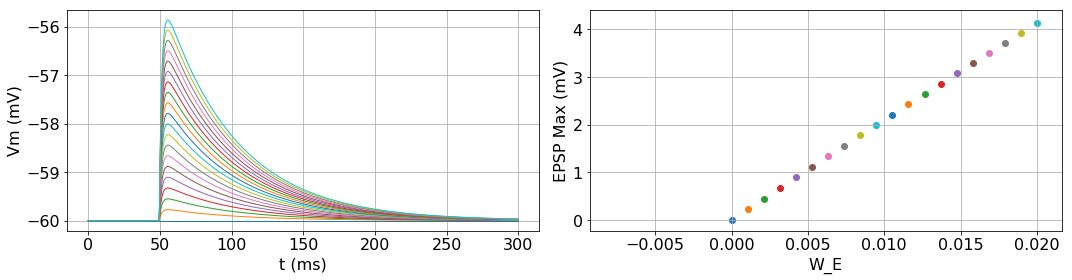

In [3]:
raise Exception  # comment out to run

def test_epsp_vs_w_e():

    DUR = 0.3
    T_IN = 0.05
    W_ES = np.linspace(0, 0.02, 20)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)
    
    for w_e in W_ES:
        
        ntwk = LIFNtwk(
            t_m=np.array([T_M]),
            e_l=np.array([E_L_0]),
            v_th=np.array([V_TH]),
            v_reset=np.array([V_RS]),
            t_r=np.array([T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': np.array([[0.]])},
            ws_up={'E': np.array([[w_e]])})

        t = np.arange(0, DUR, DT)
        spks_up = np.zeros((len(t), 1))
        spks_up[int(T_IN/DT), 0] = 1

        rsp = ntwk.run(spks_up=spks_up, dt=DT)

        axs[0].plot(1000 * t, 1000 * rsp.vs[:, 0], lw=1)
        axs[1].scatter(w_e, 1000 * (rsp.vs[:, 0].max() - rsp.vs[:, 0].min()))
    
    axs[0].set_xlabel('t (ms)')
    axs[0].set_ylabel('Vm (mV)')
    
    axs[1].set_xlabel('W_E')
    axs[1].set_ylabel('EPSP Max (mV)')

    for ax in axs:
        ax.grid()
        set_font_size(ax, 16)
        
test_epsp_vs_w_e()

### W_E = 0.01
Yields realistic ~2 mV voltage deflection.

## Noise scale

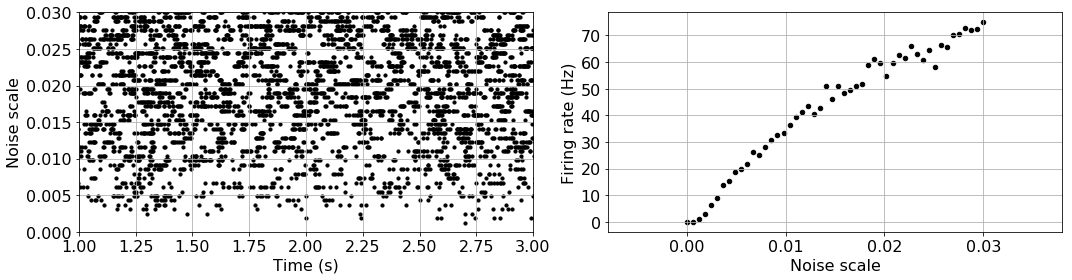

In [4]:
raise Exception  # comment out to run

def test_fr_vs_noise():
    
    DUR = 30
    WN_SCALES = np.linspace(0, 0.03, 50)
    
    np.random.seed(SEED)
    fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)
    
    ntwk = LIFNtwk(
            t_m=np.array([T_M]),
            e_l=np.array([E_L_0]),
            v_th=np.array([V_TH]),
            v_reset=np.array([V_RS]),
            t_r=np.array([T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': np.array([[0.]])},
            ws_up={'E': np.array([[0.]])})
    
    t = np.arange(0, DUR, DT)
    # make non-existent upstream spikes
    spks_up = np.zeros((len(t), 1), dtype=int)
    
    # loop over noise scales
    frs = []
    
    for scale in WN_SCALES:
        # make scaled noise input
        i_ext = np.random.normal(0, scale, len(t))
        # drive ntwk with scaled noise
        rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=i_ext)
        
        # calc resulting firing rate
        frs.append(rsp.spks[(T_START <= t), 0].sum() / (DUR - T_START))
        
        # plot raster row
        if frs[-1] > 0:
            x = t[rsp.spks[:, 0].nonzero()[0]]
            y = np.repeat(scale, len(x))
            
            axs[0].scatter(x, y, c='k', s=10)
    
    axs[0].set_xlim(1, 3)
    axs[0].set_ylim(0, WN_SCALES.max())
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Noise scale')
    
    axs[1].scatter(WN_SCALES, frs, c='k', s=20)
    axs[1].set_xlabel('Noise scale')
    axs[1].set_ylabel('Firing rate (Hz)')
    
    for ax in axs:
        ax.grid()
        set_font_size(ax, 16)
    
test_fr_vs_noise()

### WN_SCALE = 0.005
Yields realistic ~20 Hz firing rate.

## Compute baseline firing rates using chosen demo params

In [18]:
raise Exception  # comment out to run

def test_baseline_fr():
    
    DUR = 100
    W_E = 0.01
    WN_SCALE = 0.005
    
    np.random.seed(SEED)
    
    ntwk = LIFNtwk(
        t_m=np.array([T_M, T_M]),
        e_l=np.array([E_L_0, E_L_0]),
        v_th=np.array([V_TH, V_TH]),
        v_reset=np.array([V_RS, V_RS]),
        t_r=np.array([T_R, T_R]),
        es_syn={'E': E_E},
        ts_syn={'E': T_E},
        ws_rcr={'E': W_E * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
        ws_up={'E': np.array([[0.], [0]])})
    
    t = np.arange(0, DUR, DT)
    spks_up = np.zeros((len(t), 1), dtype=int)
    
    # make noise stim
    i_ext = np.random.normal(0, WN_SCALE, (len(t), 2))
    
    # drive ntwk w/ noise stim
    rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=i_ext)
    
    # get spk rates
    fr_pre, fr_post = rsp.spks[(T_START <= t), :].sum(0) / (DUR - T_START)
    
    print('FR (pre) = {0:.4f} Hz\nFR (post) = {1:.4f} Hz'.format(fr_pre, fr_post))
    
test_baseline_fr()

FR (pre) = 17.5879 Hz
FR (post) = 20.0402 Hz


# Define mutual info estimation functions

In [3]:
def bin_spks(spks, t, del_t, max_one_spk, ignore_rmd=True):
    """Bin multi-variate spike train.
    
    :param ignore_rmd: ignore final time bin if incomplete (i.e. if nonzero remainder)
    :return: binned times, spks
    """
    assert len(spks) == len(t)
    
    # get approx num dt per time bin
    dt = np.mean(np.diff(t))
    n_dt = int(np.round(del_t/dt))
    
    # convert 2D array to "stacked" 3D array
    ## get num layers
    n_layers = int(np.ceil(len(t) / n_dt))
    
    ## get cut indicating start of last layer (which might be shorter than prev layers)
    cut = (n_layers-1) * n_dt
    
    ## init array
    spks_stacked = np.zeros((n_layers, n_dt, spks.shape[1]), dtype=bool)
    
    # #fill in all but final layer
    spks_stacked[:n_layers-1] = np.split(spks[:cut], n_layers-1)
    
    ## fill in final layer
    spks_stacked[-1][:len(spks) - cut] = spks[cut:]
    
    # repeat with time vec
    t_stacked = np.nan * np.zeros((n_layers, n_dt))
    t_stacked[:n_layers-1] = np.split(t[:cut], n_layers-1)
    t_stacked[-1][:len(spks) - cut] = t[cut:]
    
    # get binned spk cts by taking sum over middle axis
    spks_binned = np.sum(spks_stacked, 1)
    # get corresponding times (nanmean since last bin might be incomplete)
    t_binned = np.nanmean(t_stacked, 1)
    
    if max_one_spk: 
        spks_binned[spks_binned > 0] = 1
        
    if len(t) % n_dt:
        return spks_binned[:-1].astype(int), t_binned[:-1]
    else:
        return spks_binned.astype(int), t_binned
    

def calc_mi(spks_binned, idx_a, idx_b, ds):
    """
    Naive mutual info calc between binned spike trains of two cells at set of integer delays.
    
    "Naive" because calcs MI from unbiased estimate of probs (but this will underestimate MI).
    
    Note: positive d means looking at b spks occurring after a spks
        (i.e. positive d is for a-->b causality)
    
    :return: list of MIs, one for each d
    """
    spks_binned = spks_binned.astype(bool)
    
    spks_binned_a = spks_binned[:, idx_a]
    spks_binned_b = spks_binned[:, idx_b]
    
    mis = []
    ps = []
    
    for d in ds:
        if d == 0:
            spks_binned_a_d = spks_binned_a
            spks_binned_b_d = spks_binned_b
        elif d > 0:
            spks_binned_a_d = spks_binned_a[:-d]
            spks_binned_b_d = spks_binned_b[d:]
        elif d < 0:
            spks_binned_a_d = spks_binned_a[-d:]
            spks_binned_b_d = spks_binned_b[:d]
        
        # estimate probabilities
        p_a = spks_binned_a_d.mean()  # p(a=1)
        p_b = spks_binned_b_d.mean()  # p(b=1)
        
        p_00 = ((~spks_binned_a_d) & (~spks_binned_b_d)).mean()  # p(a=0, b=0)
        p_10 = (spks_binned_a_d & (~spks_binned_b_d)).mean()  # p(a=1, b=0)
        p_01 = ((~spks_binned_a_d) & spks_binned_b_d).mean()  # p(a=0, b=1)
        p_11 = (spks_binned_a_d & spks_binned_b_d).mean()  # p(a=1, b=1)
        
        np.testing.assert_almost_equal(p_00 + p_10 + p_01 + p_11, 1)
        
        mi = 0
        
        if p_00:
            mi += (p_00 * (np.log2(p_00) - np.log2((1-p_a) * (1-p_b))))
        if p_10:
            mi += (p_10 * (np.log2(p_10) - np.log2(p_a * (1-p_b))))
        if p_01:
            mi += (p_01 * (np.log2(p_01) - np.log2((1-p_a) * p_b)))
        if p_11:
            mi += (p_11 * (np.log2(p_11) - np.log2(p_a * p_b)))
            
        mis.append(mi)
        ps.append(Generic(p_a=p_a, p_b=p_b, p_00=p_00, p_10=p_10, p_01=p_01, p_11=p_11))
            
    return mis, ps

## Tests

In [13]:
raise Exception

def test_binning():
    spks = np.array([
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    ], dtype=bool).T
    t = np.array([0, .0005, .001, .0015, .002, .0025, .003, .0035, .004, .0045, .005, .0055, .006])
    del_t = 0.002
    
    spks_binned_desired = np.array([
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 0],
        [0, 1, 1],
    ]).T
    
    spks_binned_actual = bin_spks(spks, t, del_t, max_one_spk=True)[0]
    
    print('Desired:')
    print(spks_binned_desired)
    
    print('Actual:')
    print(spks_binned_actual)
    
    np.testing.assert_array_equal(spks_binned_actual, spks_binned_desired)
    
    print('\nTests passed.\n')
    
test_binning()


def test_calc_mi():
    spks_binned = np.array([
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],  # 0
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],  # 1
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],  # 2
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],  # 3
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0],  # 4
    ], dtype=bool).T
    
    print('\nDesired: mi_00 == mi_01 == mi_10 > mi_02 > mi_03')
    
    mi_00 = calc_mi(spks_binned, 0, 0, ds=[0])[0][0]
    mi_01 = calc_mi(spks_binned, 0, 1, ds=[0])[0][0]
    mi_10 = calc_mi(spks_binned, 1, 0, ds=[0])[0][0]
    mi_02 = calc_mi(spks_binned, 0, 2, ds=[0])[0][0]
    mi_03 = calc_mi(spks_binned, 0, 3, ds=[0])[0][0]
    
    assert mi_00 == mi_01 == mi_10 > mi_02 > mi_03
    
    print('mi_00 = {}'.format(mi_00))
    print('mi_01 = {}'.format(mi_01))
    print('mi_10 = {}'.format(mi_01))
    print('mi_02 = {}'.format(mi_02))
    print('mi_03 = {}'.format(mi_03))
    
    print('\nDesired: mi_40_d_2 == mi_04_d_neg2 > mi_40_d_0 == mi_04_d_0')
    
    mi_40_ds = calc_mi(spks_binned, 4, 0, ds=[0, 1, 2])[0]
    mi_40_d_2 = mi_40_ds[2]
    mi_40_d_0 = mi_40_ds[0]
    
    mi_04_ds = calc_mi(spks_binned, 0, 4, ds=[0, -1, -2])[0]
    mi_04_d_neg2 = mi_04_ds[2]
    mi_04_d_0 = mi_04_ds[0]
    
    assert mi_40_d_2 == mi_04_d_neg2 > mi_40_d_0 == mi_04_d_0
    
    print('mi_40_d_2 = {}'.format(mi_40_d_2))
    print('mi_04_d_neg2 = {}'.format(mi_04_d_neg2))
    print('mi_40_d_0 = {}'.format(mi_40_d_0))
    print('mi_04_d_0 = {}'.format(mi_04_d_0))
    
    print('\nTests passed.\n')
    
test_calc_mi()

Desired:
[[1 0 1 0]
 [0 1 1 1]
 [1 1 0 1]]
Actual:
[[1 0 1 0]
 [0 1 1 1]
 [1 1 0 1]]

Tests passed.


Desired: mi_00 == mi_01 == mi_10 > mi_02 > mi_03
mi_00 = 0.9366673818775626
mi_01 = 0.9366673818775626
mi_10 = 0.9366673818775626
mi_02 = 0.5548894409556177
mi_03 = 0.03266352574517187

Desired: mi_40_d_2 == mi_04_d_neg2 > mi_40_d_0 == mi_04_d_0
mi_40_d_2 = 0.9709505944546686
mi_04_d_neg2 = 0.9709505944546686
mi_40_d_0 = 0.03673442288657437
mi_04_d_0 = 0.03673442288657437

Tests passed.



# Compute mutual info increase vs resting potential

## Test that MI increases when synaptic weight increases


W_E = 0:
FR (pre) = 17.9098 Hz
FR (post) = 18.1903 Hz

W_E = 0.01:
FR (pre) = 17.9098 Hz
FR (post) = 19.3923 Hz

W_E = 0.02:
FR (pre) = 17.9098 Hz
FR (post) = 20.6678 Hz

W_E = 0.03:
FR (pre) = 17.9098 Hz
FR (post) = 21.9032 Hz


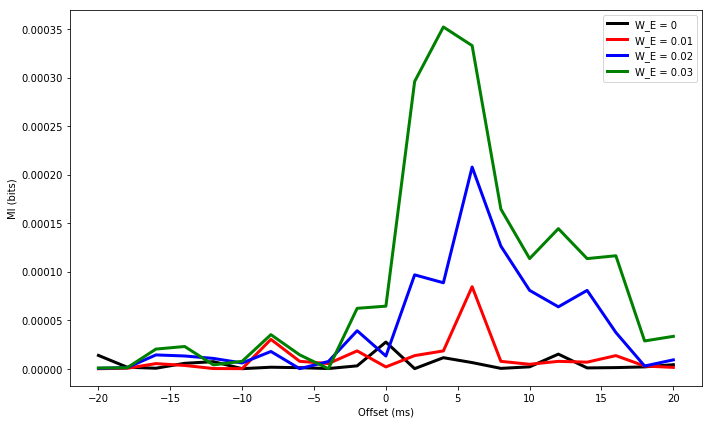

In [5]:
def test_mi_vs_w_e():
    
    DUR = 300
    W_E = 0.01
    WN_SCALE = 0.005
    
    W_ES = [0, W_E, 2*W_E, 3*W_E]
    COLORS = ['k', 'r', 'b', 'g']
    
    DS = np.arange(-10, 11, dtype=int)
    
    np.random.seed(SEED)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)
    
    t = np.arange(0, DUR, DT)
    spks_up = np.zeros((len(t), 1), dtype=int)
    
    # make noise stim
    i_ext = np.random.normal(0, WN_SCALE, (len(t), 2))
    
    # loop over w_e values
    for w_e, c in zip(W_ES, COLORS):
        
        ntwk = LIFNtwk(
            t_m=np.array([T_M, T_M]),
            e_l=np.array([E_L_0, E_L_0]),
            v_th=np.array([V_TH, V_TH]),
            v_reset=np.array([V_RS, V_RS]),
            t_r=np.array([T_R, T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': w_e * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
            ws_up={'E': np.array([[0.], [0]])})
    
        # drive ntwk w/ noise stim
        rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=i_ext)
    
        # get spk rates
        fr_pre, fr_post = rsp.spks[(T_START <= t), :].sum(0) / (DUR - T_START)

        print('\nW_E = {0}:\nFR (pre) = {1:.4f} Hz\nFR (post) = {2:.4f} Hz'.format(w_e, fr_pre, fr_post))
    
        # bin spikes
        spks_binned = bin_spks(rsp.spks, rsp.ts, DEL_T, max_one_spk=True)[0]
        mi = calc_mi(spks_binned, 0, 1, DS)[0]
        
        ax.plot(1000 * DS * DEL_T, mi, c=c, lw=3)
        
    ax.set_xlabel('Offset (ms)')
    ax.set_ylabel('MI (bits)')
    
    ax.legend(['W_E = {}'.format(w_e) for w_e in W_ES])
    
test_mi_vs_w_e()

## Measure change in MI when pre- and post-syn. excitability changes


E_L_1 = -0.06:
FR (pre) = 6.8468 Hz
FR (post) = 7.4715 Hz

E_L_1 = -0.055:
FR (pre) = 9.1912 Hz
FR (post) = 10.1682 Hz

E_L_1 = -0.05:
FR (pre) = 11.8559 Hz
FR (post) = 13.2833 Hz

E_L_1 = -0.045:
FR (pre) = 14.8468 Hz
FR (post) = 16.8008 Hz


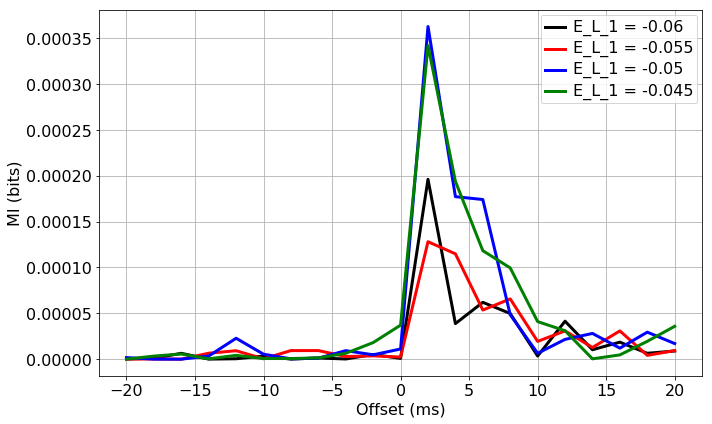

In [23]:
def test_mi_vs_e_l():
    
    DUR = 500
    W_E = 0.02
    WN_SCALE = 0.0025
    
    E_L_1S = [-0.06, -0.055, -0.05, -0.045]
    
    COLORS = ['k', 'r', 'b', 'g']
    
    DS = np.arange(-10, 11, dtype=int)
    
    np.random.seed(2)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)
    
    t = np.arange(0, DUR, DT)
    spks_up = np.zeros((len(t), 1), dtype=int)
    
    # make noise stim
    i_ext = np.random.normal(0, WN_SCALE, (len(t), 2))
    
    # loop over e_l_1 values
    for e_l_1, c in zip(E_L_1S, COLORS):
        
        ntwk = LIFNtwk(
            t_m=np.array([T_M, T_M]),
            e_l=np.array([e_l_1, e_l_1]),
            v_th=np.array([V_TH, V_TH]),
            v_reset=np.array([V_RS, V_RS]),
            t_r=np.array([T_R, T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': W_E * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
            ws_up={'E': np.array([[0.], [0]])})
    
        # drive ntwk w/ noise stim
        rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=i_ext)
    
        # get spk rates
        fr_pre, fr_post = rsp.spks[(T_START <= t), :].sum(0) / (DUR - T_START)

        print('\nE_L_1 = {0}:\nFR (pre) = {1:.4f} Hz\nFR (post) = {2:.4f} Hz'.format(e_l_1, fr_pre, fr_post))
    
        # bin spikes
        spks_binned = bin_spks(rsp.spks, rsp.ts, DEL_T, max_one_spk=True)[0]
        mi = calc_mi(spks_binned, 0, 1, DS)[0]
        
        ax.plot(1000 * DS * DEL_T, mi, c=c, lw=3)
        
    ax.set_xlabel('Offset (ms)')
    ax.set_ylabel('MI (bits)')
    
    ax.legend(['E_L_1 = {}'.format(e_l_1) for e_l_1 in E_L_1S])
    
    ax.grid()
    set_font_size(ax, 16)
    
test_mi_vs_e_l()


E_L_1 = -0.06:
FR (pre) = 6.8468 Hz
FR (post) = 7.4715 Hz

E_L_1 = -0.055:
FR (pre) = 9.1912 Hz
FR (post) = 7.7397 Hz

E_L_1 = -0.05:
FR (pre) = 11.8559 Hz
FR (post) = 8.0581 Hz

E_L_1 = -0.045:
FR (pre) = 14.8468 Hz
FR (post) = 8.3804 Hz


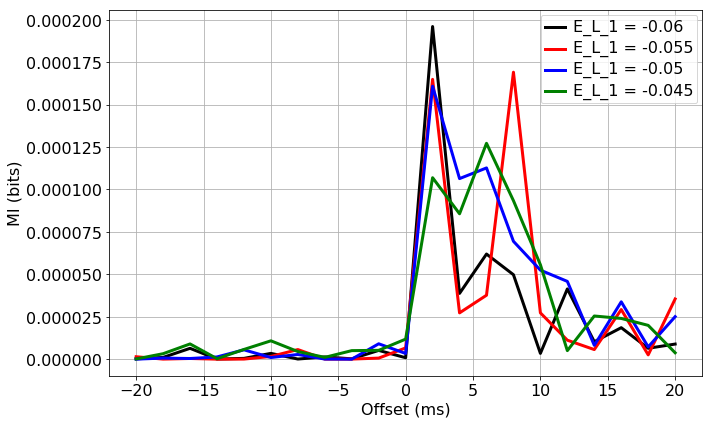

In [24]:
def test_mi_vs_e_l():
    
    DUR = 500
    W_E = 0.02
    WN_SCALE = 0.0025
    
    E_L_1S = [-0.06, -0.055, -0.05, -0.045]
    
    COLORS = ['k', 'r', 'b', 'g']
    
    DS = np.arange(-10, 11, dtype=int)
    
    np.random.seed(2)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)
    
    t = np.arange(0, DUR, DT)
    spks_up = np.zeros((len(t), 1), dtype=int)
    
    # make noise stim
    i_ext = np.random.normal(0, WN_SCALE, (len(t), 2))
    
    # loop over e_l_1 values
    for e_l_1, c in zip(E_L_1S, COLORS):
        
        ntwk = LIFNtwk(
            t_m=np.array([T_M, T_M]),
            e_l=np.array([e_l_1, E_L_0]),
            v_th=np.array([V_TH, V_TH]),
            v_reset=np.array([V_RS, V_RS]),
            t_r=np.array([T_R, T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': W_E * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
            ws_up={'E': np.array([[0.], [0]])})
    
        # drive ntwk w/ noise stim
        rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=i_ext)
    
        # get spk rates
        fr_pre, fr_post = rsp.spks[(T_START <= t), :].sum(0) / (DUR - T_START)

        print('\nE_L_1 = {0}:\nFR (pre) = {1:.4f} Hz\nFR (post) = {2:.4f} Hz'.format(e_l_1, fr_pre, fr_post))
    
        # bin spikes
        spks_binned = bin_spks(rsp.spks, rsp.ts, DEL_T, max_one_spk=True)[0]
        mi = calc_mi(spks_binned, 0, 1, DS)[0]
        
        ax.plot(1000 * DS * DEL_T, mi, c=c, lw=3)
        
    ax.set_xlabel('Offset (ms)')
    ax.set_ylabel('MI (bits)')
    
    ax.legend(['E_L_1 = {}'.format(e_l_1) for e_l_1 in E_L_1S])
    
    ax.grid()
    set_font_size(ax, 16)
    
test_mi_vs_e_l()


E_L_1 = -0.06:
FR (pre) = 6.8468 Hz
FR (post) = 7.4715 Hz

E_L_1 = -0.055:
FR (pre) = 6.8468 Hz
FR (post) = 9.8238 Hz

E_L_1 = -0.05:
FR (pre) = 6.8468 Hz
FR (post) = 12.5966 Hz

E_L_1 = -0.045:
FR (pre) = 6.8468 Hz
FR (post) = 15.6436 Hz


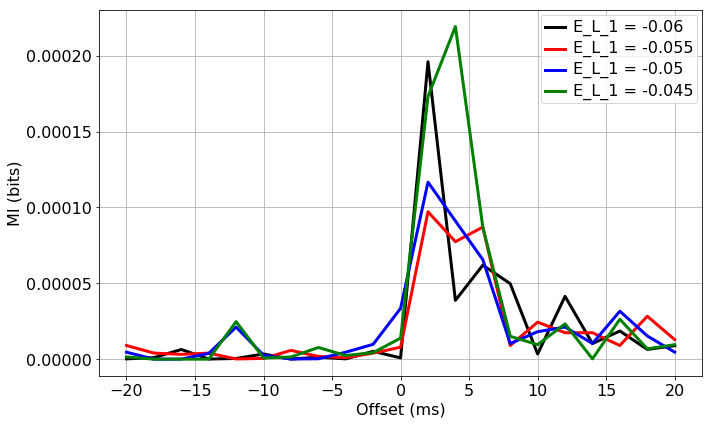

In [25]:
def test_mi_vs_e_l():
    
    DUR = 500
    W_E = 0.02
    WN_SCALE = 0.0025
    
    E_L_1S = [-0.06, -0.055, -0.05, -0.045]
    
    COLORS = ['k', 'r', 'b', 'g']
    
    DS = np.arange(-10, 11, dtype=int)
    
    np.random.seed(2)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)
    
    t = np.arange(0, DUR, DT)
    spks_up = np.zeros((len(t), 1), dtype=int)
    
    # make noise stim
    i_ext = np.random.normal(0, WN_SCALE, (len(t), 2))
    
    # loop over e_l_1 values
    for e_l_1, c in zip(E_L_1S, COLORS):
        
        ntwk = LIFNtwk(
            t_m=np.array([T_M, T_M]),
            e_l=np.array([E_L_0, e_l_1]),
            v_th=np.array([V_TH, V_TH]),
            v_reset=np.array([V_RS, V_RS]),
            t_r=np.array([T_R, T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': W_E * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
            ws_up={'E': np.array([[0.], [0]])})
    
        # drive ntwk w/ noise stim
        rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=i_ext)
    
        # get spk rates
        fr_pre, fr_post = rsp.spks[(T_START <= t), :].sum(0) / (DUR - T_START)

        print('\nE_L_1 = {0}:\nFR (pre) = {1:.4f} Hz\nFR (post) = {2:.4f} Hz'.format(e_l_1, fr_pre, fr_post))
    
        # bin spikes
        spks_binned = bin_spks(rsp.spks, rsp.ts, DEL_T, max_one_spk=True)[0]
        mi = calc_mi(spks_binned, 0, 1, DS)[0]
        
        ax.plot(1000 * DS * DEL_T, mi, c=c, lw=3)
        
    ax.set_xlabel('Offset (ms)')
    ax.set_ylabel('MI (bits)')
    
    ax.legend(['E_L_1 = {}'.format(e_l_1) for e_l_1 in E_L_1S])
        
    ax.grid()
    set_font_size(ax, 16)
    
test_mi_vs_e_l()

# Examine MI dependence on E_L_1, WN_SCALE, and W_E

## Vary E_L_1 and WN_SCALE

In [42]:
W_E = 0.02
WN_SCALES = np.linspace(0.001, 0.006, 5)
E_L_1S = np.linspace(-0.06, -0.045, 7)

E_L_1_FIXED = -0.05
WN_SCALE_FIXED = 0.0025

DUR = 1000

DEL_T = 0.002
DS = np.arange(-10, 11, dtype=int)


np.random.seed(SEED)

# loop over WN_SCALES and E_L_1S
t = np.arange(0, DUR, DT)
spks_up = np.zeros((len(t), 1), dtype=int)
i_ext = np.random.normal(0, 1, ((len(t), 2)))

frs_pre_wn_scale_e_l_1 = np.nan * np.zeros((len(WN_SCALES), len(E_L_1S)))
frs_post_wn_scale_e_l_1 = np.nan * np.zeros((len(WN_SCALES), len(E_L_1S)))

mis_wn_scale_e_l_1 = np.nan * np.zeros((len(WN_SCALES), len(E_L_1S), len(DS)))
mi_peaks_wn_scale_e_l_1 = np.nan * np.zeros((len(WN_SCALES), len(E_L_1S)))

for w_ctr, wn_scale in enumerate(WN_SCALES):
    sys.stdout.write('\nWN_SCALE = {0:.5f} : '.format(wn_scale))
    
    for e_ctr, e_l_1 in enumerate(E_L_1S):
        sys.stdout.write('.')
        # make ntwk
        ntwk = LIFNtwk(
            t_m=np.array([T_M, T_M]),
            e_l=np.array([e_l_1, e_l_1]),
            v_th=np.array([V_TH, V_TH]),
            v_reset=np.array([V_RS, V_RS]),
            t_r=np.array([T_R, T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': W_E * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
            ws_up={'E': np.array([[0.], [0]])})
        
        # drive ntwk w/ scaled noise
        rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=wn_scale*i_ext)
        
        # calc/store spk rates
        fr_pre, fr_post = rsp.spks[(T_START <= t), :].sum(0) / (DUR - T_START)
        frs_pre_wn_scale_e_l_1[w_ctr, e_ctr] = fr_pre
        frs_post_wn_scale_e_l_1[w_ctr, e_ctr] = fr_post
        
        # calc mi
        spks_binned = bin_spks(rsp.spks, rsp.ts, DEL_T, max_one_spk=True)[0]
        mi = np.array(calc_mi(spks_binned, 0, 1, DS)[0])
        
        mis_wn_scale_e_l_1[w_ctr, e_ctr, :] = mi.copy()
        mi_peaks_wn_scale_e_l_1[w_ctr, e_ctr] = mi.max()


WN_SCALE = 0.00100 : .......
WN_SCALE = 0.00225 : .......
WN_SCALE = 0.00350 : .......
WN_SCALE = 0.00475 : .......
WN_SCALE = 0.00600 : .......

### Compare increasing both pre and post leak potential vs just pre or just post

In [53]:
# compare pre & post E_L increase vs just pre or just post
idx_pre = 0
idx_post = 1

mis_pre_e_l_1 = np.nan * np.zeros((len(E_L_1S), len(DS)))
mi_pre_peaks_e_l_1 = np.nan * np.zeros(len(E_L_1S))
mis_post_e_l_1 = np.nan * np.zeros((len(E_L_1S), len(DS)))
mi_post_peaks_e_l_1 = np.nan * np.zeros(len(E_L_1S))

for idx in [idx_pre, idx_post]:
    
    if idx == idx_pre:
        sys.stdout.write('\nPRE : ')
    elif idx == idx_post:
        sys.stdout.write('\nPOST : ')
        
    for e_ctr, e_l_1 in enumerate(E_L_1S):
        sys.stdout.write('.')
        
        e_l = np.array([E_L_0, E_L_0])
        e_l[idx] = e_l_1

        ntwk = LIFNtwk(
            t_m=np.array([T_M, T_M]),
            e_l=e_l,
            v_th=np.array([V_TH, V_TH]),
            v_reset=np.array([V_RS, V_RS]),
            t_r=np.array([T_R, T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': W_E * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
            ws_up={'E': np.array([[0.], [0]])})

        # drive ntwk w/ scaled noise
        rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=WN_SCALE_FIXED*i_ext)

        # calc mi
        spks_binned = bin_spks(rsp.spks, rsp.ts, DEL_T, max_one_spk=True)[0]
        mi = np.array(calc_mi(spks_binned, 0, 1, DS)[0])

        if idx == idx_pre:
            mis_pre_e_l_1[e_ctr, :] = mi.copy()
            mi_pre_peaks_e_l_1[e_ctr] = mi.max()

        elif idx == idx_post:
            mis_post_e_l_1[e_ctr, :] = mi.copy()
            mi_post_peaks_e_l_1[e_ctr] = mi.max()


PRE : .......
POST : .......

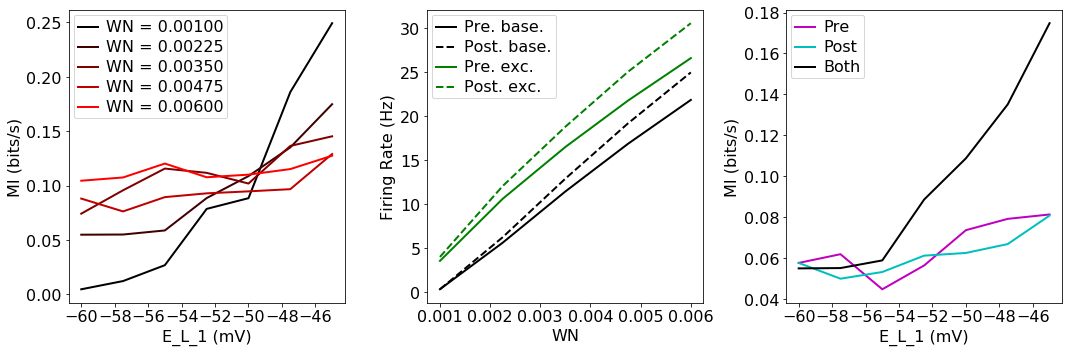

In [54]:
E_L_1_FIXED = -0.05

# make plots
colors = np.transpose([
    np.linspace(0, 1, len(WN_SCALES)),
    np.zeros(len(WN_SCALES)),
    np.linspace(0, 0, len(WN_SCALES))])  # black to red

fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

# pre->post MI vs. noise scale and leak potential
for w_ctr, (wn_scale, color) in enumerate(zip(WN_SCALES, colors)):
    mi_peaks_e_l_1 = mi_peaks_wn_scale_e_l_1[w_ctr]
    axs[0].plot(1000 * E_L_1S, mi_peaks_e_l_1 / DEL_T, color=color, lw=2)
    
axs[0].set_xlabel('E_L_1 (mV)')
axs[0].set_ylabel('MI (bits/s)')
axs[0].legend(['WN = {0:.5f}'.format(wn_scale) for wn_scale in WN_SCALES], loc='best')

# baseline firing rates vs noise scale
e_l_1_idx = idx_closest(E_L_1_FIXED, E_L_1S)

axs[1].plot(WN_SCALES, frs_pre_wn_scale_e_l_1[:, 0], c='k', lw=2, ls='-')
axs[1].plot(WN_SCALES, frs_post_wn_scale_e_l_1[:, 0], c='k', lw=2, ls='--')

axs[1].plot(WN_SCALES, frs_pre_wn_scale_e_l_1[:, e_l_1_idx], c='g', lw=2, ls='-')
axs[1].plot(WN_SCALES, frs_post_wn_scale_e_l_1[:, e_l_1_idx], c='g', lw=2, ls='--')

axs[1].set_xlabel('WN')
axs[1].set_ylabel('Firing Rate (Hz)')
axs[1].legend(['Pre. base.', 'Post. base.', 'Pre. exc.', 'Post. exc.'], loc='best')

# comparisons of both vs pre. or post. only
wn_scale_idx = idx_closest(WN_SCALE_FIXED, WN_SCALES)

axs[2].plot(1000 * E_L_1S, mi_pre_peaks_e_l_1 / DEL_T, color='m', lw=2)
axs[2].plot(1000 * E_L_1S, mi_post_peaks_e_l_1 / DEL_T, color='c', lw=2)
axs[2].plot(1000 * E_L_1S, mi_peaks_wn_scale_e_l_1[wn_scale_idx] / DEL_T, color='k', lw=2)

axs[2].set_xlabel('E_L_1 (mV)')
axs[2].set_ylabel('MI (bits/s)')
axs[2].legend(['Pre', 'Post', 'Both'], loc='best')

for ax in axs:
    set_font_size(ax, 16)

## Vary W_E


WN_SCALE = 0.00100 : .......
WN_SCALE = 0.00225 : .......
WN_SCALE = 0.00350 : .......
WN_SCALE = 0.00475 : .......
WN_SCALE = 0.00600 : .......
PRE : .......
POST : .......
WN_SCALE = 0.00100 : .......
WN_SCALE = 0.00225 : .......
WN_SCALE = 0.00350 : .......
WN_SCALE = 0.00475 : .......
WN_SCALE = 0.00600 : .......
PRE : .......
POST : .......
WN_SCALE = 0.00100 : .......
WN_SCALE = 0.00225 : .......
WN_SCALE = 0.00350 : .......
WN_SCALE = 0.00475 : .......
WN_SCALE = 0.00600 : .......
PRE : .......
POST : .......
WN_SCALE = 0.00100 : .......
WN_SCALE = 0.00225 : .......
WN_SCALE = 0.00350 : .......
WN_SCALE = 0.00475 : .......
WN_SCALE = 0.00600 : .......
PRE : .......
POST : .......

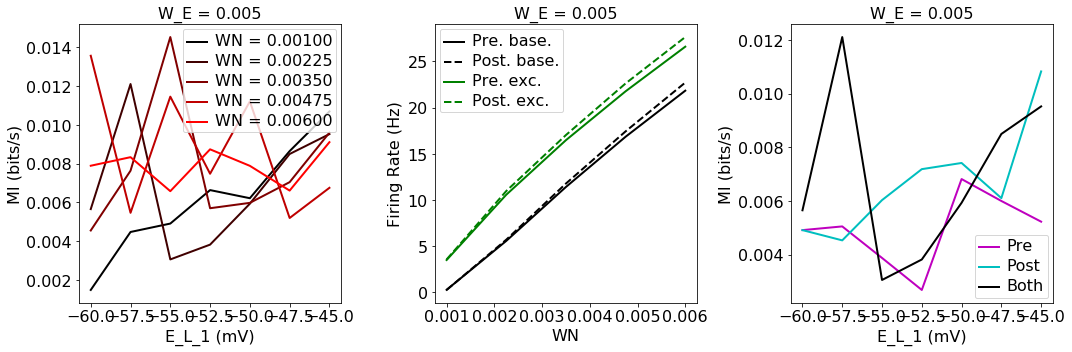

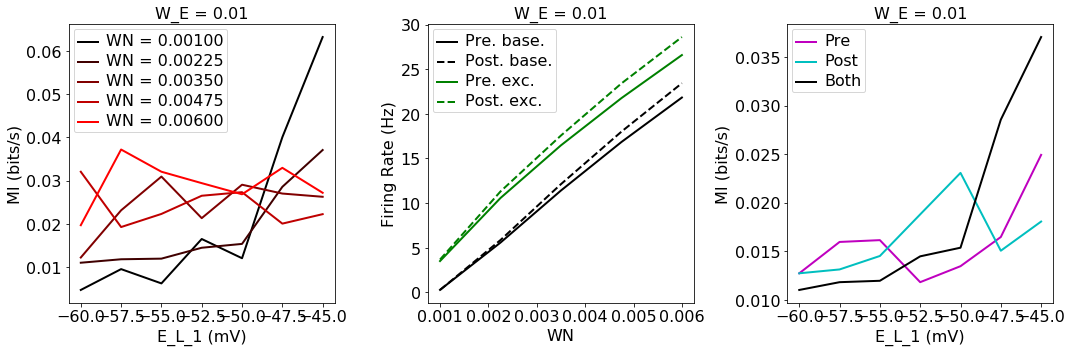

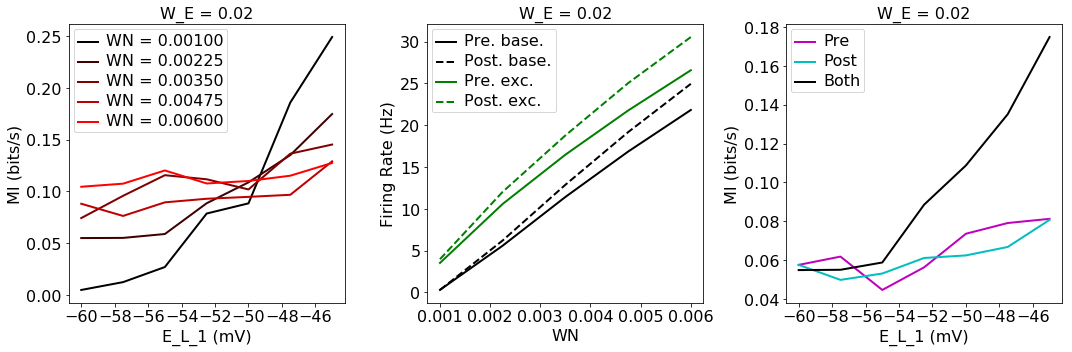

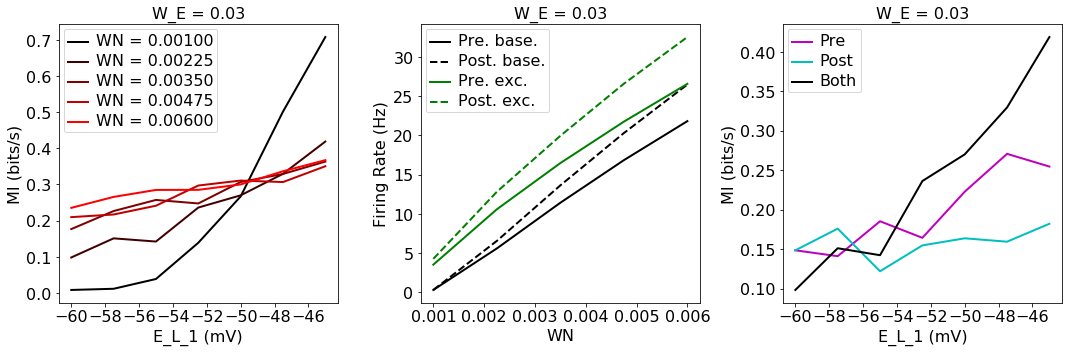

In [57]:
for W_E in [0.005, 0.01, 0.02, 0.03]:
    WN_SCALES = np.linspace(0.001, 0.006, 5)
    E_L_1S = np.linspace(-0.06, -0.045, 7)

    E_L_1_FIXED = -0.05
    WN_SCALE_FIXED = 0.0025

    DUR = 1000

    DEL_T = 0.002
    DS = np.arange(-10, 11, dtype=int)


    np.random.seed(SEED)

    # loop over WN_SCALES and E_L_1S
    t = np.arange(0, DUR, DT)
    spks_up = np.zeros((len(t), 1), dtype=int)
    i_ext = np.random.normal(0, 1, ((len(t), 2)))

    frs_pre_wn_scale_e_l_1 = np.nan * np.zeros((len(WN_SCALES), len(E_L_1S)))
    frs_post_wn_scale_e_l_1 = np.nan * np.zeros((len(WN_SCALES), len(E_L_1S)))

    mis_wn_scale_e_l_1 = np.nan * np.zeros((len(WN_SCALES), len(E_L_1S), len(DS)))
    mi_peaks_wn_scale_e_l_1 = np.nan * np.zeros((len(WN_SCALES), len(E_L_1S)))

    for w_ctr, wn_scale in enumerate(WN_SCALES):
        sys.stdout.write('\nWN_SCALE = {0:.5f} : '.format(wn_scale))

        for e_ctr, e_l_1 in enumerate(E_L_1S):
            sys.stdout.write('.')
            # make ntwk
            ntwk = LIFNtwk(
                t_m=np.array([T_M, T_M]),
                e_l=np.array([e_l_1, e_l_1]),
                v_th=np.array([V_TH, V_TH]),
                v_reset=np.array([V_RS, V_RS]),
                t_r=np.array([T_R, T_R]),
                es_syn={'E': E_E},
                ts_syn={'E': T_E},
                ws_rcr={'E': W_E * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
                ws_up={'E': np.array([[0.], [0]])})

            # drive ntwk w/ scaled noise
            rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=wn_scale*i_ext)

            # calc/store spk rates
            fr_pre, fr_post = rsp.spks[(T_START <= t), :].sum(0) / (DUR - T_START)
            frs_pre_wn_scale_e_l_1[w_ctr, e_ctr] = fr_pre
            frs_post_wn_scale_e_l_1[w_ctr, e_ctr] = fr_post

            # calc mi
            spks_binned = bin_spks(rsp.spks, rsp.ts, DEL_T, max_one_spk=True)[0]
            mi = np.array(calc_mi(spks_binned, 0, 1, DS)[0])

            mis_wn_scale_e_l_1[w_ctr, e_ctr, :] = mi.copy()
            mi_peaks_wn_scale_e_l_1[w_ctr, e_ctr] = mi.max()

    # compare pre & post E_L increase vs just pre or just post
    idx_pre = 0
    idx_post = 1

    mis_pre_e_l_1 = np.nan * np.zeros((len(E_L_1S), len(DS)))
    mi_pre_peaks_e_l_1 = np.nan * np.zeros(len(E_L_1S))
    mis_post_e_l_1 = np.nan * np.zeros((len(E_L_1S), len(DS)))
    mi_post_peaks_e_l_1 = np.nan * np.zeros(len(E_L_1S))

    for idx in [idx_pre, idx_post]:
    
        if idx == idx_pre:
            sys.stdout.write('\nPRE : ')
        elif idx == idx_post:
            sys.stdout.write('\nPOST : ')

        for e_ctr, e_l_1 in enumerate(E_L_1S):
            sys.stdout.write('.')

            e_l = np.array([E_L_0, E_L_0])
            e_l[idx] = e_l_1

            ntwk = LIFNtwk(
                t_m=np.array([T_M, T_M]),
                e_l=e_l,
                v_th=np.array([V_TH, V_TH]),
                v_reset=np.array([V_RS, V_RS]),
                t_r=np.array([T_R, T_R]),
                es_syn={'E': E_E},
                ts_syn={'E': T_E},
                ws_rcr={'E': W_E * np.array([[0., 0], [1, 0]])},  # single cxn from nrn 0 to nrn 1
                ws_up={'E': np.array([[0.], [0]])})

            # drive ntwk w/ scaled noise
            rsp = ntwk.run(spks_up=spks_up, dt=DT, i_ext=WN_SCALE_FIXED*i_ext)

            # calc mi
            spks_binned = bin_spks(rsp.spks, rsp.ts, DEL_T, max_one_spk=True)[0]
            mi = np.array(calc_mi(spks_binned, 0, 1, DS)[0])

            if idx == idx_pre:
                mis_pre_e_l_1[e_ctr, :] = mi.copy()
                mi_pre_peaks_e_l_1[e_ctr] = mi.max()

            elif idx == idx_post:
                mis_post_e_l_1[e_ctr, :] = mi.copy()
                mi_post_peaks_e_l_1[e_ctr] = mi.max()

    E_L_1_FIXED = -0.05

    # make plots
    colors = np.transpose([
        np.linspace(0, 1, len(WN_SCALES)),
        np.zeros(len(WN_SCALES)),
        np.linspace(0, 0, len(WN_SCALES))])  # black to red

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

    # pre->post MI vs. noise scale and leak potential
    for w_ctr, (wn_scale, color) in enumerate(zip(WN_SCALES, colors)):
        mi_peaks_e_l_1 = mi_peaks_wn_scale_e_l_1[w_ctr]
        axs[0].plot(1000 * E_L_1S, mi_peaks_e_l_1 / DEL_T, color=color, lw=2)

    axs[0].set_xlabel('E_L_1 (mV)')
    axs[0].set_ylabel('MI (bits/s)')
    axs[0].legend(['WN = {0:.5f}'.format(wn_scale) for wn_scale in WN_SCALES], loc='best')

    # baseline firing rates vs noise scale
    e_l_1_idx = idx_closest(E_L_1_FIXED, E_L_1S)

    axs[1].plot(WN_SCALES, frs_pre_wn_scale_e_l_1[:, 0], c='k', lw=2, ls='-')
    axs[1].plot(WN_SCALES, frs_post_wn_scale_e_l_1[:, 0], c='k', lw=2, ls='--')

    axs[1].plot(WN_SCALES, frs_pre_wn_scale_e_l_1[:, e_l_1_idx], c='g', lw=2, ls='-')
    axs[1].plot(WN_SCALES, frs_post_wn_scale_e_l_1[:, e_l_1_idx], c='g', lw=2, ls='--')

    axs[1].set_xlabel('WN')
    axs[1].set_ylabel('Firing Rate (Hz)')
    axs[1].legend(['Pre. base.', 'Post. base.', 'Pre. exc.', 'Post. exc.'], loc='best')

    # comparisons of both vs pre. or post. only
    wn_scale_idx = idx_closest(WN_SCALE_FIXED, WN_SCALES)

    axs[2].plot(1000 * E_L_1S, mi_pre_peaks_e_l_1 / DEL_T, color='m', lw=2)
    axs[2].plot(1000 * E_L_1S, mi_post_peaks_e_l_1 / DEL_T, color='c', lw=2)
    axs[2].plot(1000 * E_L_1S, mi_peaks_wn_scale_e_l_1[wn_scale_idx] / DEL_T, color='k', lw=2)

    axs[2].set_xlabel('E_L_1 (mV)')
    axs[2].set_ylabel('MI (bits/s)')
    axs[2].legend(['Pre', 'Post', 'Both'], loc='best')

    for ax in axs:
        ax.set_title('W_E = {}'.format(W_E))
        set_font_size(ax, 16)